<h1 style="text-align: center;"><b>Black-Scholes-Merton model</b></h1>

#### Roland Grinis, Ivan Novikov, Evgeny Filipov, Maksim Sosnin


In [1]:
import torch
import math
import numpy as np
import numba as nb
from typing import Tuple, List
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use("dark_background")
%matplotlib inline

torch.manual_seed(987654);

## 1 Black-Scholes Formulae

### 1.1 Forward dynamics with constant volatility
This model describes the evolution the forward $f_t$ via GBM dynamics:

$$
\text{d}f_t = \mu f_t\text{d}t + \sigma f_t \text{d}W_t
$$

The volatility $\sigma$ is called the *implied volatility* and is provided by market participants. Being constant is a severe limitation for practitioners, but we will address this issue with stochastic volatility models later.

Calibrating the drift $\mu$ is not possible without apriori information which fundamentally depends on each investor's view on the market.

The ingenious idea was to note that the choice of $\mu$ is linked to the choice of probability measure $\mathbb{P}$.

### 1.2 Existence of Risk-Neutral Measure

In the BSM model, substituting:
$$
\gamma = \frac{\mu}{\sigma}
$$
into Girsanov's result leads to martingale dynamics for the forward:
$$
\text{d}f_t = \sigma f_t \text{d}W^\gamma_t
$$
under $\mathbb{Q}^\gamma$. To avoid arbitrage, the forward values of all derivative contracts must also be martingales under that measure. 

As a special case, assuming constant instantaneous spot interest rate $r>0$ and having the zero-coupon bond as numéraire:
$$
f_t = e^{r(T-t)}S_t
$$

we can derive the Black-Scholes model for the underlying:
$$
\text{d}S_t = r S_t\text{d}t + \sigma S_t \text{d}W^\gamma_t
$$

which is not a martingale anymore.

Does the valuation we obtained in the risk neutral world is the fair price for the actual measure $\mathcal{P}$?

### 1.3 Black-Scholes PDE

Let's start again from the BSM model. Considering European contracts for simplicity, the  Feynman-Kac formula for the risk-neutral dynamics gives:
$$
\frac{\partial FV}{\partial t} + \frac{1}{2}\sigma^2 f_t^2 \frac{\partial^2 FV}{\partial f_t^2}=0
$$

This is also known as the *Black-Scholes PDE*.

### 1.4 Replication

By Ito and the above, under the measure $\mathbb{P}$, the derivative's $FV_t$ evolves as:
$$
\begin{split}
\text{d}FV_t & = \left(\frac{\partial FV}{\partial t}+ \mu f_t \frac{\partial FV}{\partial f_t} + \frac{1}{2}\sigma^2 f_t^2 \frac{\partial^2 FV}{\partial f_t^2} \right)\text{d}t + \sigma f_t\frac{\partial FV}{\partial f_t} dW_t \\
 & =  \mu f_t \frac{\partial FV}{\partial f_t}\text{d}t   + \sigma f_t\frac{\partial FV}{\partial f_t} dW_t \\
 & = \frac{\partial FV}{\partial f_t} df_t
\end{split}
$$

and so we can exactly replicate the derivative by trading in the forward on the underlying as dictated by $\partial FV / \partial f_t$ - the so called *delta*. 

By no-arbitrage principle, we conclude that the risk neutral price is fair for *any* measure $\mathbb{P}$ within the framework of the BSM model.

### 1.6 Analytic formulae

Under the BSM model:
$$
\frac{\text{d}f_t}{f_t} = \sigma \text{d}W_t
$$

The forward value of a European Call at strike $K$ and maturity date $T$ is given by:
$$
FV_C = f_t \text{N}(d_{+}) - K \text{N}(d_{-})
$$

where $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is the standard normal CDF and:
$$
d_{\pm} = \frac{\log \frac{f_t}{K} \pm \frac{1}{2}\sigma^2(T-t) }{\sigma \sqrt{T-t}  } 
$$


For the European Put, one can rely on the put-call parity $FV_C - FV_P = f_t - K$:
$$
FV_P = -f_t \text{N}(-d_{+}) + K \text{N}(- d_{-})
$$

#### 1.6.1 Greeks

There are three main risk sensitivies:
* *Delta* $\Delta$ measures the exposure to the underlying:
$$
\begin{split}
 \Delta & \equiv \frac{\partial FV_C}{\partial f} = \text{N}(d_{+})   \\
 \Delta & \equiv \frac{\partial FV_P}{\partial f} = - \text{N}(-d_{+}) = \text{N}(d_{+}) - 1
\end{split}
$$

* *Vega* (also often called *Kappa*) is the exposure to volatility:
$$
\mathcal{V} \equiv \frac{\partial FV_C}{\partial \sigma} = \frac{\partial FV_P}{\partial \sigma} = \text{N}'(d_{+}) f_t \sqrt{T-t}
$$
* *Curvature* is supposed to measure the convexity:
$$
\Upsilon \equiv \frac{\sigma}{\left(f_t\sigma \sqrt{T-t}\right)^2} \mathcal{V} = \frac{\text{N}'(d_{+})}{f_t\sigma \sqrt{T-t}}
$$

The definition of curvature above is somewhat of an abuse of terminology as we should have been capturing second order information with *Gamma*:
$$
\Gamma \equiv \frac{\partial^2 FV_C}{\partial f^2} = \frac{\partial^2 FV_P}{\partial f^2} = \frac{\text{N}'(d_{+})}{f_t\sigma \sqrt{T-t}}
$$

But higher order derivatives are expensive to compute. And as we can easily see, in the special case of BSM this is justified via what is known the *Gamma-Vega relation*.

Finally, another quantity of interest is *Theta* - the decay of the value of optionality over time:
$$
 \Theta \equiv \frac{\partial FV_C}{\partial t}= \frac{\partial FV_P}{\partial t} = - \frac{\sigma f_t \text{N}'(d_{+})}{2 \sqrt{T-t}}  
$$

In [2]:
normal = torch.distributions.Normal(0,1)
N = normal.cdf
logNp = normal.log_prob

In [3]:
def BS_call_FV(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    d2 = d1 - sigma*torch.sqrt(dt)
    return forward*N(d1) - strike*N(d2)

In [4]:
def BS_call_Delta(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return N(d1)

In [5]:
def BS_call_Vega(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return torch.exp(logNp(d1)) * forward * torch.sqrt(dt)

In [6]:
def BS_call_Gamma(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return torch.exp(logNp(d1)) / (forward * sigma * torch.sqrt(dt))

In [7]:
def BS_call_Theta(forward, time_t, strike, maturity, sigma):
    dt = maturity - time_t
    d1 = (torch.log(forward / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
    return - forward * sigma * torch.exp(logNp(d1)) / (2 * torch.sqrt(dt))

In [8]:
forward, time_t = torch.meshgrid(
    torch.linspace(50, 150, steps=200),
    torch.linspace(0, 1, steps=200)[:-1], indexing='xy')
strike = torch.tensor([100.])
maturity = torch.tensor([1.])
sigma = 0.3

In [9]:
FV = BS_call_FV(forward, time_t, strike, maturity, sigma)
Delta = BS_call_Delta(forward, time_t, strike, maturity, sigma)
Vega = BS_call_Vega(forward, time_t, strike, maturity, sigma)
Curvature = BS_call_Gamma(forward, time_t, strike, maturity, sigma)
Theta = BS_call_Theta(forward, time_t, strike, maturity, sigma)

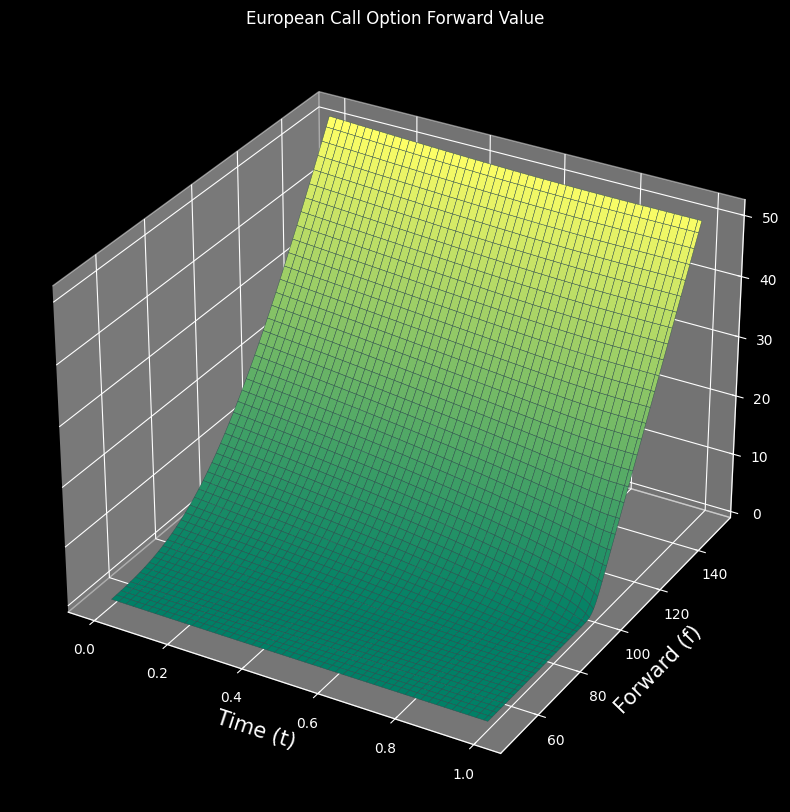

In [10]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), FV.numpy(),
                cmap='summer', edgecolors='darkslategray', lw=.3)
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Forward Value')
plt.grid(True)
plt.show()

See on interactive plot:

In [ ]:
fig = go.Figure(data=[go.Surface(z=FV.numpy(), x=forward.numpy(),
                                 y=time_t.numpy(), colorscale='Tealgrn_r')])
fig.update_layout(title='European Call Option Forward Value')
fig.update_scenes(xaxis_title_text='f',
                  yaxis_title_text='t',
                  zaxis_title_text='FV')
fig.show()

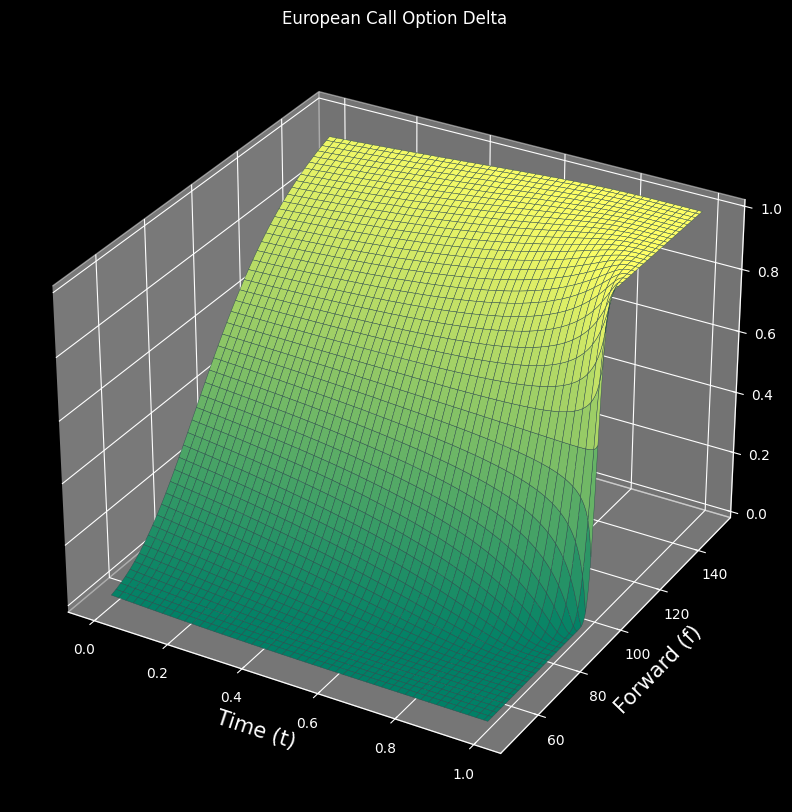

In [11]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Delta.numpy(),
                cmap='summer', edgecolors='darkslategray', lw=.3)
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Delta')
plt.show()

In [ ]:
figD = go.Figure(data=[go.Surface(z=Delta.numpy(), x=forward.numpy(),
                                  y=time_t.numpy(), colorscale='Tealgrn_r')])
figD.update_layout(title='European Call Option Delta')
figD.update_scenes(xaxis_title_text='f',
                  yaxis_title_text='t',
                  zaxis_title_text='Delta')
figD.show()

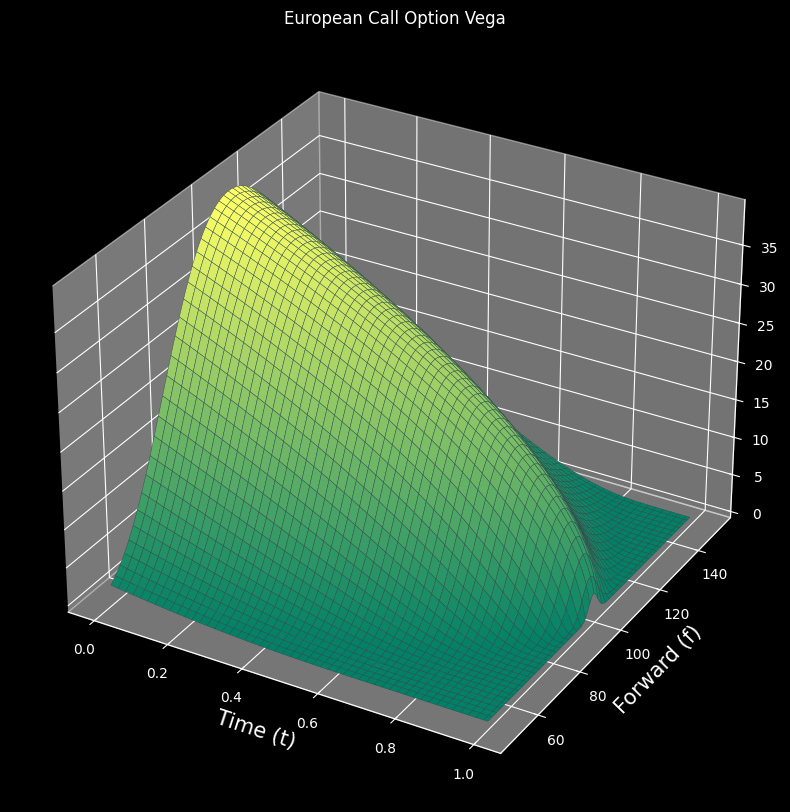

In [12]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Vega.numpy(),
                cmap='summer', edgecolors='darkslategray', lw=.3)
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Vega')
plt.show()

In [ ]:
figV = go.Figure(data=[go.Surface(z=Vega.numpy(), x=forward.numpy(),
                                  y=time_t.numpy(), colorscale='Tealgrn_r')])
figV.update_layout(title='European Call Option Vega')
figV.update_scenes(xaxis_title_text='f',
                  yaxis_title_text='t',
                  zaxis_title_text='Vega')
figV.show()

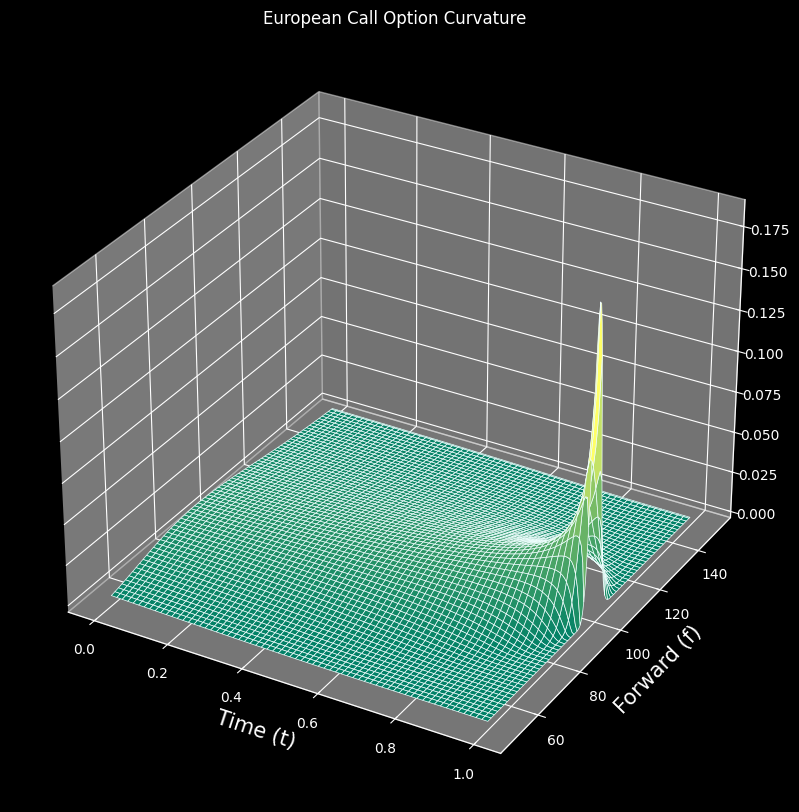

In [13]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Curvature.numpy(),
                cmap='summer', edgecolors='azure', lw=.5, rcount=70, ccount=70)
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Curvature')
plt.show()

In [ ]:
figC = go.Figure(data=[go.Surface(z=Curvature.numpy(), x=forward.numpy(),
                                  y=time_t.numpy(), colorscale='Tealgrn_r')])
figC.update_layout(title='European Call Option Curvature')
figC.update_scenes(xaxis_title_text='f',
                  yaxis_title_text='t',
                  zaxis_title_text='Curvature')
figC.show()

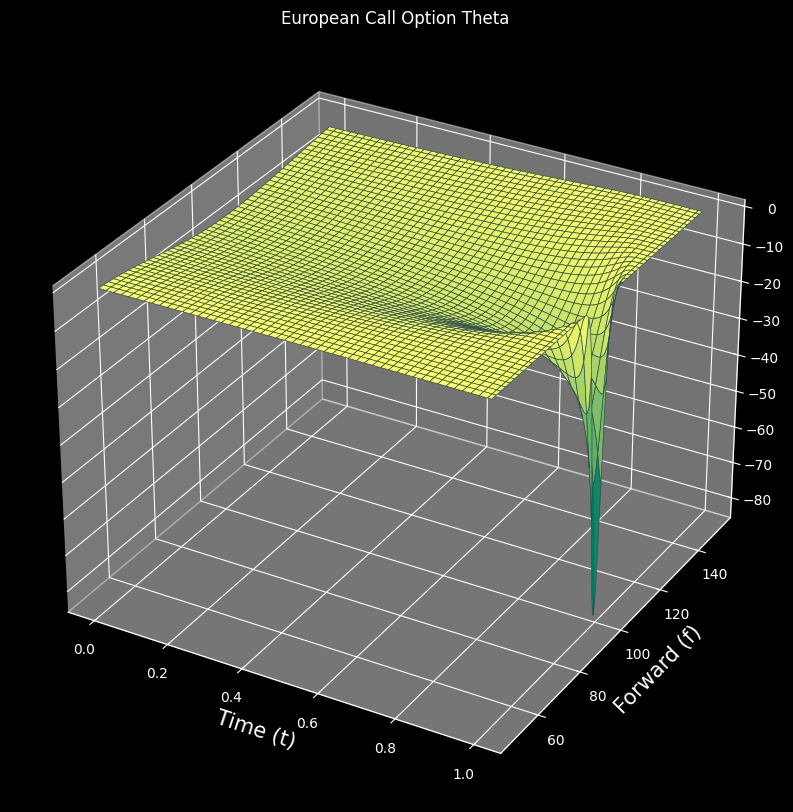

In [14]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(time_t.numpy(), forward.numpy(), Theta.numpy(),
                cmap='summer', edgecolors='darkslategray', lw=.5)
plt.xlabel('Time (t)', color='white', fontsize=15)
plt.ylabel('Forward (f)', color='white', fontsize=15)
plt.title('European Call Option Theta')
plt.show()

In [ ]:
figT = go.Figure(data=[go.Surface(z=Theta.numpy(), x=forward.numpy(),
                                  y=time_t.numpy(), colorscale='Tealgrn_r')])
figT.update_layout(title='European Call Option Theta')
figT.update_scenes(xaxis_title_text='f',
                  yaxis_title_text='t',
                  zaxis_title_text='Theta')
figT.show()

#### 1.6.2 Exercise: Put Delta
Implement and plot the delta for the Put.

## 2 The Binomial Method
Consider a discrete model for a stock price $S_0, S_{t_1}, \dots, S_{t_M}$ with $t_{i+1} = t_i + \Delta t$ and:

\begin{equation*} 
\begin{split}
\mathbb{P} \left(S_{t_{i+1}} = u S_{t_i} \right) & = p \\
\mathbb{P} \left(S_{t_{i+1}} = d S_{t_i} \right) & = 1 - p
\end{split}
\end{equation*}
for constants  $0 <d < u$ such that $u \cdot d=1$ and a probability $0 < p < 1$. We assume a constant continuously compounded interest rate $r > 0$ and the zero-coupon $P(t,T) = e^{-r(T-t)}$ as numéraire.

### 2.1 Approximating the Black-Scholes SDE
Setting:
\begin{equation*} 
\begin{split}
p & = \frac{e^{r\Delta t} - d}{u - d} \\
u & = \beta + \sqrt{\beta^2 -1}
\end{split}
\end{equation*}

where: 
$$
\beta = \frac{1}{2}\left(e^{-r\Delta t} + e^{(r+\sigma^2)\Delta t}\right)
$$

we obtain a discretisation for:
$$
\text{d}S_t = r S_t\text{d}t + \sigma S_t \text{d}W_t
$$

with linear weak convergence $O(\Delta t)$.


### 2.2 European options

#### 2.2.1 Pricing algorithm
Let's start with $t_0 = 0$ and assume a maturity $t_M = 1$, we get $\Delta t = \frac1{M}$. Let us denote:
$$
S_{j,i} = S_0 u^j d^{i - j} = S_0 u^{2j - i}
$$ 
where $i$ corresponds to time $t_i$ and $j$ is a number of time periods before $t_i$ when price goes up.

According to risk neutral dynamics for European option price
$$
    PV_{j,i} = e^{-r \Delta t} (p PV_{j + 1,i + 1} + (1 - p) PV_{j,i + 1})
$$

with final time at maturity given by $PV_{j,M} = (S_{j, M} - K)^{+}$ for the call option payoff, and $PV_{j,M} = (K - S_{j, M})^{+}$ if we want the put.

In [15]:
M = 100
S_0 = 50
K = 70
sigma = 0.5
r = 0.01

@nb.njit()
def get_proba(r, sigma, M):
    beta = 0.5*(np.exp(-r/M) + np.exp((r + sigma**2)/M))
    u = beta + np.sqrt(beta**2 - 1)
    d = 1 / u
    return u, (np.exp(r / M) - d) / (u - d)

u, p = get_proba(r, sigma, M)
print(p)
print(u)

0.48849450588566157
1.0513012161296376


In [16]:
# return the price of a call option at maturity t_M = 1 where j is number of upward moves
@nb.njit()
def price_mature_call(S_0, K, u, M):
    d = 1 / u
    S_M = np.zeros(M + 1)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return np.maximum(S_M - K, 0)

In [17]:
# use recurrent formula to calculate the price for previous period
@nb.njit()
def price_previous_layer(r, M, p, current_layer):
    return np.exp(- r / M) * (p * current_layer[1:] + \
      (1 - p) * current_layer[:-1])

In [18]:
@nb.njit()
def price_european_call(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_layer = price_mature_call(S_0, K, u, M)
    for layer in range(M):
        current_layer = price_previous_layer(r, M, p, current_layer)
    return current_layer[0]
price_european_call(S_0, K, sigma, r, M)

4.493118505184732

#### 2.2.2 Exercise: Weak convergence
Check we have weak convergence of order $O(\Delta t)$ with Black-Scholes formulae.
#### 2.2.2 Exercise: The European Put
Price the European Put with the above method and compare your result with Black-Scholes formulae.

#### 2.2.4 Replication
Let us choose $\Delta$ at time $t_i$ such that the portfolio become riskless at time $t_{i+1}$:
\begin{equation*} 
\begin{split}
\Pi_i & = e^{-r \Delta t} \Pi_{i+1} \\
& = S_i \Delta - PV_i
\end{split}
\end{equation*}
where the portfolio $\Pi_i$ consists of a positon $\Delta$ in the underlying $S_i$ and a short position in the option contract.

Solving the above for $\Delta$ gives:
\begin{equation*} 
\begin{split}
u S_i \Delta - PV_{i+1}^{(u)} & = d S_i \Delta - PV_{i+1}^{(d)} \\
\Rightarrow \Delta & = \frac{PV_{i+1}^{(u)} - PV_{i+1}^{(d)}}{S_i(u - d)}
\end{split}
\end{equation*}

#### 2.2.5 Exercise:  Exact replication
Add the missing steps in the above calculations and check that we replicate the option *exactly*.

### 2.3 The American Put

#### 2.3.1 Dynamic Programming 

Applying the Dynamic Programming Principle to the European Put Option, we can price recursively the American Put Option:
\begin{equation*} 
\begin{split}
  &PV_{j,M} = (K - S_{j, M})^{+} \\
  &PV_{j,i} = \max \left\{(K - S_{j, i})^{+}, e^{-r \Delta t} (p PV_{j + 1,i + 1} + (1 - p) PV_{j,i + 1}) \right\}
\end{split}
\end{equation*}


In [19]:
@nb.njit()
def get_maturity_underlying(S_0, K, u, M):
    d = 1/u
    S_M = np.zeros(M + 1)
    for j in range(M + 1):
        S_M[j] = S_0 * (u ** j) * (d ** (M - j))
    return S_M

In [20]:
K = 35
@nb.njit()
def price_american_put(S_0, K, sigma, r, M):
    u, p = get_proba(r, sigma, M)
    current_underlying = get_maturity_underlying(S_0, K, u, M)
    current_layer = np.maximum(K - current_underlying, 0)
    for layer in range(M):
        continuation_value = price_previous_layer(r, M, p, current_layer)
        current_underlying = current_underlying[:-1] * u
        intrinsic_value = np.maximum(K - current_underlying, 0)
        current_layer = np.maximum(intrinsic_value, continuation_value)
    return current_layer[0]
price_american_put(S_0, K, sigma, r, M)

2.7838339945172637

#### 2.3.2 Exercise: Exact replication
Check that exactly the same formula for $\Delta$ holds, and we can replicate the Americal Put exactly
#### 2.3.3 Exercise: The Americal Call
Price the American call with the above method and compare your result with the European Call

## 3 Solving the Black-Scholes PDE

In this section we again consider the special case of constant interest rates $r>0$ and take the zero coupon $P(t,T) = e^{-r(T-t)}$ as numéraire. The underlying then follows:
$$
\text{d}S_t = r S_t\text{d}t + \sigma S_t \text{d}W_t
$$

### 3.1 Black-Scholes PDE 

The present value $PV(t,S_t) = e^{r(T-t)}FV(t,S_t)$ must be a martingale and by Feyman-Kac solves in $0 \leq t \leq T$ and  $S > 0$:
$$
\frac{\partial PV}{\partial t} + \frac12 \frac{\partial^2 PV}{\partial S^2} \sigma^2 S^2 + \frac{\partial PV}{\partial S} rS = rPV
$$

This is the well-known Black-Scholes PDE.

#### 3.1.1 Initial Value Problem for Vanilla Options

At maturity $t = T$ the call option present value is $PV_C(T, S)= (S - K)^+$. If $S \rightarrow 0$, the option becomes worthless $PV_C \rightarrow 0$ (note: the underlying $S$ will never become $>0$ in GBM). 

On the other hand, if $S$ becomes very large, then the option will almost certainly
be exercised, and the exercise price is negligible compared to $S$: $PV_C(t, S) \sim S$ as $S \rightarrow \infty$. 

Therefore, the initial conditions for the call should be:
\begin{equation}
\begin{aligned}
  &PV_C(T,S) = (S - K)^+ \\
  &PV_C(t,0) = 0 \\
  &PV_C(t, S) \sim S \text{ as } S \rightarrow \infty
\end{aligned}
\end{equation}

Similarly, we obtain the initial conditions for the put's present value $PV_P$:
\begin{equation}
\begin{aligned}
  &PV_P(T,S) = (K - S)^+ \\
  &PV_P(t,0) = K e^{-r(T - t)} \\
  &PV_P(t, S) \rightarrow 0 \text{ as } S \rightarrow \infty
\end{aligned}
\end{equation}

#### 3.1.2 The Heat Equation

Let us transform the Black-Scholes PDE into a heat equation.
\begin{equation}
  S = K e^x, t = T - \frac{2\tau}{\sigma^2}
\end{equation}

We introduce:
\begin{equation}
  v(\tau, x) = v \left( \frac{\sigma^2}{2} (T - t), \ln(S / K)\right) = \frac{1}{K} PV(t,S) 
\end{equation}

Then this gives us:
\begin{equation}
  \frac{\partial PV}{\partial t} = K \frac{\partial v}{\partial \tau} \frac{\partial \tau}{\partial t} = - \frac{K \sigma^2}{2} \frac{\partial v}{\partial \tau}
\end{equation}

\begin{equation}
  \frac{\partial PV}{\partial S} = K \frac{\partial v}{\partial x} \frac{\partial x}{\partial S} = \frac{K}{S} \frac{\partial v}{\partial x}
\end{equation}

So we get:
\begin{equation}
  \frac{\partial^2 PV}{\partial S^2} = K \frac{\partial}{\partial S}\left(\frac{\partial v}{\partial S}\right) = \frac{\partial}{\partial S}\left(\frac{K}{S} \frac{\partial v}{\partial x}\right) = -\frac{K}{S^2} \frac{\partial v}{\partial x} + \frac{K}{S} \frac{\partial^2 v}{\partial x^2} \frac{\partial x}{\partial S} = -\frac{K}{S^2} \frac{\partial v}{\partial x} + \frac{K}{S^2} \frac{\partial^2 v}{\partial x^2}
\end{equation}


Hence, substituting the new derivatives back into the Black-Scholes PDE and grouping terms:
\begin{equation}
  \frac{\partial v}{\partial \tau} = \frac{\partial^2 v}{\partial x^2} + ( k - 1)\frac{\partial v}{\partial x} - k v
\end{equation}
where $k = \frac{2r}{\sigma^2}$, $-\infty < x < \infty$, $0 \le \tau \le \frac{\sigma^2}{2} T$.

The equation above is still not the heat equation. To simplify even further, we can write:
\begin{equation}
  v(\tau, x) = e^{\alpha x + \beta \tau} y(\tau, x)
\end{equation}

Differentiating, we find:
\begin{equation}
  \frac{\partial v}{\partial \tau} = e^{\alpha x + \beta \tau} \left(\beta u + \frac{\partial u}{\partial \tau}\right)
\end{equation}

\begin{equation}
  \frac{\partial v}{\partial x} = e^{\alpha x + \beta \tau} \left(\alpha y + \frac{\partial y}{\partial x}\right)
\end{equation}

\begin{equation}
  \frac{\partial^2 v}{\partial x^2} = e^{\alpha x + \beta \tau} \left(\alpha^2 y + 2 \alpha \frac{\partial y}{\partial x} + \frac{\partial^2 y}{\partial x^2} \right)
\end{equation}

Finally, we obtain:
\begin{equation}
  \beta y + \frac{\partial y}{\partial \tau} = \alpha^2 y + 2 \alpha \frac{\partial y}{\partial x} + \frac{\partial^2 y}{\partial x^2} + (k - 1)\left(\alpha y + \frac{\partial y}{\partial x}\right) - ky
\end{equation}

\begin{equation}
  \frac{\partial y}{\partial \tau} = \frac{\partial^2 y}{\partial x^2} + (k - 1 + 2\alpha) \frac{\partial y}{\partial x} + (\alpha^2 + \alpha k - \alpha - k - \beta) y
\end{equation}

We now choose $\alpha$ and $\beta$ to eliminate the last two terms:
\begin{equation}
  \alpha = - \frac{k - 1}{2}
\end{equation}

\begin{equation}
  \beta = \alpha^2 + \alpha k - \alpha - k = - \frac14 (k + 1)^2
\end{equation}

Therefore:
\begin{equation}
  \frac{\partial y}{\partial \tau} = \frac{\partial^2 y}{\partial x^2}
\end{equation}
where $-\infty < x < \infty$, $0 \le \tau \le \frac{\sigma^2}{2} T$. Now we can rewrite the initial conditions. Recall that
\begin{equation}
  PV(t, S) = K e^{\alpha x + \beta \tau} y(\tau, x)
\end{equation}

In the case of a call option we get:
\begin{equation}
\begin{aligned}
  &y(0, x) = e^{-\alpha x} (e^x - 1, 0)^+ = (e^{(k+1)x/2} - e^{(k-1)x/2})^+ \\
  &y(\tau, x) \rightarrow 0 \text{ as } x \rightarrow -\infty \\
  &y(\tau, x) \sim e^{(k+1)x/2 + (k+1)^2 \tau / 4} \text{ as } x \rightarrow \infty
\end{aligned}
\end{equation}

Similarly, the boundary conditions for a put:
\begin{equation}
\begin{aligned}
  &y(0, x) = e^{-\alpha x} (1 - e^x, 0)^+ = (e^{(k-1)x/2} - e^{(k+1)x/2})^+ \\
  &y(\tau, x) = e^{(k-1)x/2 + (k-1)^2 \tau/4} \text{ as } x \rightarrow -\infty \\
  &y(\tau, x) \rightarrow 0 \text{ as } x \rightarrow \infty
\end{aligned}
\end{equation}

### 3.2 Finite-Differences Methods

We start first with the naive approach:

#### 3.2.1 Explicit Method

In the PDE, replace
\begin{equation}
\begin{aligned}
  &\frac{\partial y_{i, \nu}}{\partial \tau} = \frac{y_{i, \nu + 1} - y_{i, \nu}}{\Delta \tau} + O(\Delta \tau) \\
  &\frac{\partial^2 y_{i, \nu}}{\partial x^2} = \frac{y_{i + 1, \nu} - 2y_{i, \nu} + y_{i - 1, \nu}}{\Delta x^2} + O(\Delta x^2)
\end{aligned}
\end{equation}
where $x \in [x_{min}, x_{max}]$, $\tau \in [0, \tau_{max}]$, $x_i = x_{min} + i \cdot \Delta x$, $\tau_i = \nu \cdot \Delta \tau$. 

The order of convergence is $O(\Delta \tau, \Delta x^2)$.

Denote $w \rightarrow y$ the numerical solution on the grid and drop the $O$-errors:
\begin{equation}
  w_{i, \nu + 1} = w_{i, \nu} + \frac{\Delta \tau}{\Delta x^2} (w_{i + 1, \nu} - 2w_{i, \nu} + w_{i - 1, \nu})
\end{equation}
With the notation $\lambda = \frac{\Delta \tau}{\Delta x^2}$ this is rewritten as
\begin{equation}
  w_{i, \nu + 1} = \lambda w_{i - 1, \nu} + (1 - 2 \lambda) w_{i, \nu} + \lambda w_{i + 1, \nu}
\end{equation}
Or
\begin{equation}
  w^{(\nu + 1)} = A w^{(\nu)}
\end{equation}
where $w^{(\nu)} = (w_{0, \nu}, ... , w_{m, \nu})^T$, $m = \frac{x_{max} - x_{min}}{\Delta x}$ and
\begin{equation}
  A = \left(
    \begin{array}{ccccc}
      1 - 2\lambda & \lambda & 0 & \ldots & 0 \\
      \lambda & 1 - 2\lambda & \ddots & \ddots & \vdots \\
      0 & \ddots & \ddots & \ddots & 0 \\
      \vdots & \ddots & \ddots & \ddots & \lambda \\
      0 & \ldots & 0 & \lambda & 1 - 2\lambda
    \end{array}
  \right)
\end{equation}

#### 3.2.2 Boundary Conditions for Discretization

Since $x$ is unlimited, we should choose the boundaries of $x$ artificially: $x \in [x_{min}, x_{max}]$. The sides of the rectangle should be large enough depending on the precision. Recall that we have $w(\tau, x_{min}) \approx y(\tau, x_{min}) \approx y(\tau, x) \text{ as } x \rightarrow -\infty$ and $w(\tau, x_{max}) \approx y(\tau, x_{max}) \approx y(\tau, x) \text{ as } x \rightarrow \infty$. In addition, our interval should include $x$ values, which correspond to $S_0$ and $K$:
\begin{equation}
  x_{min} < \min{\left\{0, \ln{\frac{S_0}{K}} \right\}}, \max{\left\{0, \ln{\frac{S_0}{K}} \right\}} < x_{max}
\end{equation}

#### 3.2.3 Stability Considerations

For a stable behaviour, we require $A^\nu e^{(0)} \rightarrow 0$ for $\nu \rightarrow \infty$, where $e^{(0)}$ is intial rounding error. This results into a requirement the spectral radius $\rho(A) = \max\limits_k{|\mu_k^A|} < 1$ where $\mu_k^A$ is eigenvalue of $A$.

One can show that $\mu_k^A= 1 - 4\lambda \sin^2 \frac{k \pi}{2m}$. Stability is obtained when $-1 < 1 - 4\lambda \sin^2 \frac{k \pi}{2m} < 1$, so for $0 < \lambda \le \frac12$ the explicit method is stable.

In [21]:
@nb.njit()
def get_call_maturity_condition(x_min, x_max, delta_x, k):
    x = np.arange(x_min, x_max + delta_x, delta_x)
    payoff = np.exp((k + 1) * x / 2) - np.exp((k - 1) * x / 2)
    return np.maximum(payoff, 0)

In [22]:
@nb.njit()
def get_explicit_matrix(m, lambda_):
    A = np.zeros((m + 1, m + 1))
    for i in range(m):
        A[i][i] = 1 - 2 * lambda_
        A[i][i + 1] = lambda_
        A[i + 1][i] = lambda_
    A[m][m] = 1 - 2 * lambda_
    return A

In [23]:
@nb.njit()
def explicit_call(w, A, k, delta_tau):
    new_w = A.dot(w)
    # boundary conditions w[0] -> y(x_min), w[-1] -> y(x_max)
    new_w[0] = 0
    new_w[-1] = w[-1] * np.exp((k + 1) ** 2 * delta_tau / 4)
    return new_w

In [24]:
k = 0.5
x_min = -5
x_max = 5
delta_x = 0.5
delta_tau = 0.1

@nb.njit()
def compute_explicit_call(k, x_min, x_max, delta_x, delta_tau):
    m = int((x_max - x_min) / delta_x)
    lambda_ = delta_tau / (delta_x ** 2)
    A = get_explicit_matrix(m, lambda_)
    w = get_call_maturity_condition(x_min, x_max, delta_x, k)
    for _ in range(50):
        w = explicit_call(w, A, k, delta_tau)
    return np.linspace(x_min, x_max, m+1), w

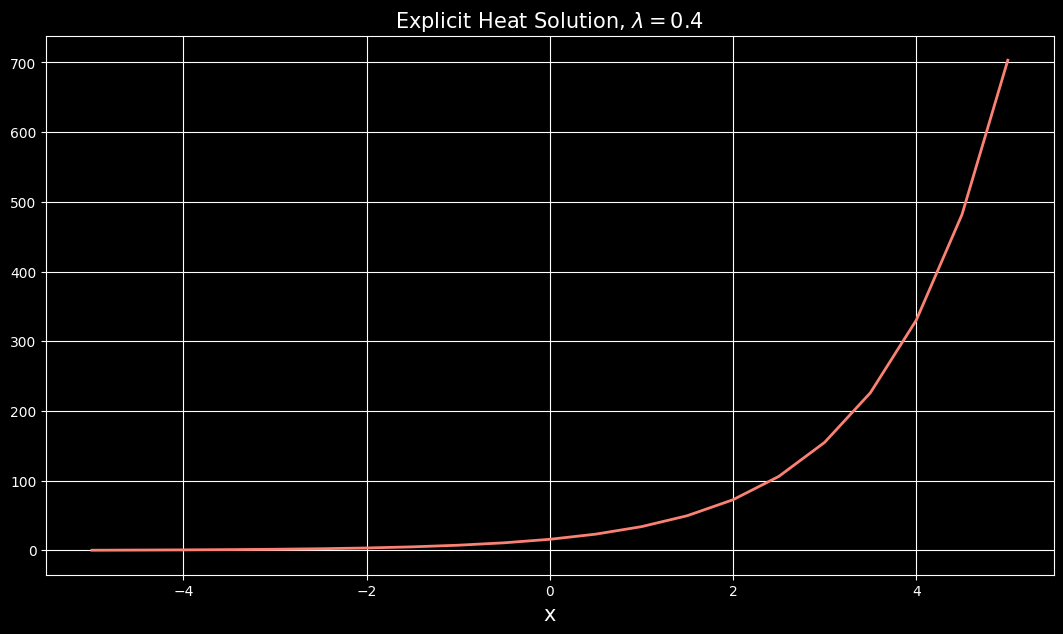

In [25]:
x, w = compute_explicit_call(k, x_min, x_max, delta_x, delta_tau)
plt.figure(figsize=(13, 7))
plt.plot(x, w, 'C3', lw=2)
plt.title('Explicit Heat Solution, $\lambda = 0.4$', fontsize=15)
plt.xlabel('x', color='white', fontsize=15)
plt.grid()
plt.show()

We can see that for $\lambda = 0.4$ the solution is stable. For $\lambda = 0.6$ the solution is unstable:

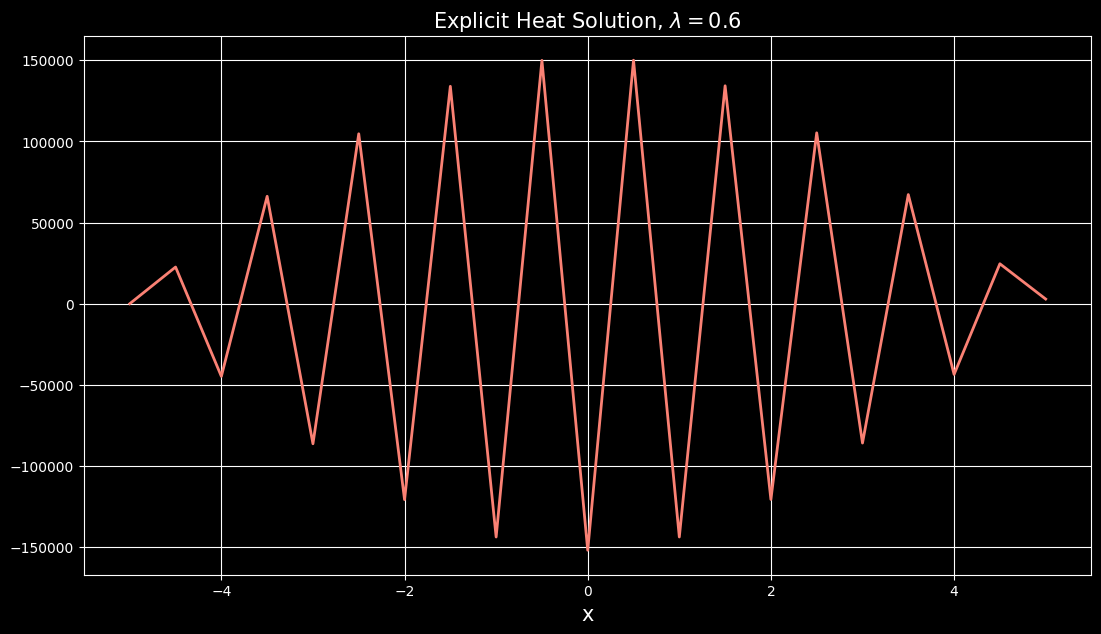

In [26]:
delta_tau = 0.15
x, wu = compute_explicit_call(k, x_min, x_max, delta_x, delta_tau)
plt.figure(figsize=(13, 7))
plt.plot(x, wu, 'C3', lw=2)
plt.title('Explicit Heat Solution, $\lambda = 0.6$', fontsize=15)
plt.xlabel('x', color='white', fontsize=15)
plt.grid()
plt.show()

#### 3.2.4 Implicit Method

In the PDE, replace
\begin{equation}
\begin{aligned}
  &\frac{\partial y_{i, \nu}}{\partial \tau} = \frac{y_{i, \nu} - y_{i, \nu - 1}}{\Delta \tau} + O(\Delta \tau) \\
  &\frac{\partial^2 y_{i, \nu}}{\partial x^2} = \frac{y_{i + 1, \nu} - 2y_{i, \nu} + y_{i - 1, \nu}}{\Delta x^2} + O(\Delta x^2)
\end{aligned}
\end{equation}

The order of convergence is $O(\Delta \tau, \Delta x^2)$.

\begin{equation}
  - \lambda w_{i + 1, \nu} + (1 + 2 \lambda) w_{i, \nu} - \lambda w_{i - 1, \nu} = w_{i, \nu - 1}
\end{equation}
Or
\begin{equation}
  Aw^{(\nu + 1)} = w^{(\nu)}
\end{equation}
where
\begin{equation}
  A = \left(
    \begin{array}{ccccc}
      1 + 2\lambda & -\lambda & 0 & \ldots & 0 \\
      -\lambda & 1 + 2\lambda & \ddots & \ddots & \vdots \\
      0 & \ddots & \ddots & \ddots & 0 \\
      \vdots & \ddots & \ddots & \ddots & -\lambda \\
      0 & \ldots & 0 & -\lambda & 1 + 2\lambda
    \end{array}
  \right)
\end{equation}

One can find eigenvalues of A and show that implicit method is unconditionally stable. In particular for $\lambda = 0.6$ the solution is stable.

In [27]:
@nb.njit()
def get_implicit_matrix(m, lambda_):
    A = np.zeros((m + 1, m + 1))
    for i in range(m):
        A[i][i] = 1 + 2 * lambda_
        A[i][i + 1] = -lambda_
        A[i + 1][i] = -lambda_
    A[m][m] = 1 + 2 * lambda_
    return A

In [28]:
k = 0.5
x_min = -5
x_max = 5
delta_x = 0.2
delta_tau = 0.05

@nb.njit()
def compute_implicit_call(k, x_min, x_max, delta_x, delta_tau):
    m = int((x_max - x_min) / delta_x)
    lambda_ = delta_tau / (delta_x ** 2)
    A = get_implicit_matrix(m, lambda_)
    inv_A = np.linalg.inv(A)
    w = get_call_maturity_condition(x_min, x_max, delta_x, k)
    for _ in range(50):
      # we can use explicit iteration whith inverse A
      w = explicit_call(w, inv_A, k, delta_tau)
    return np.linspace(x_min, x_max, m+1), w

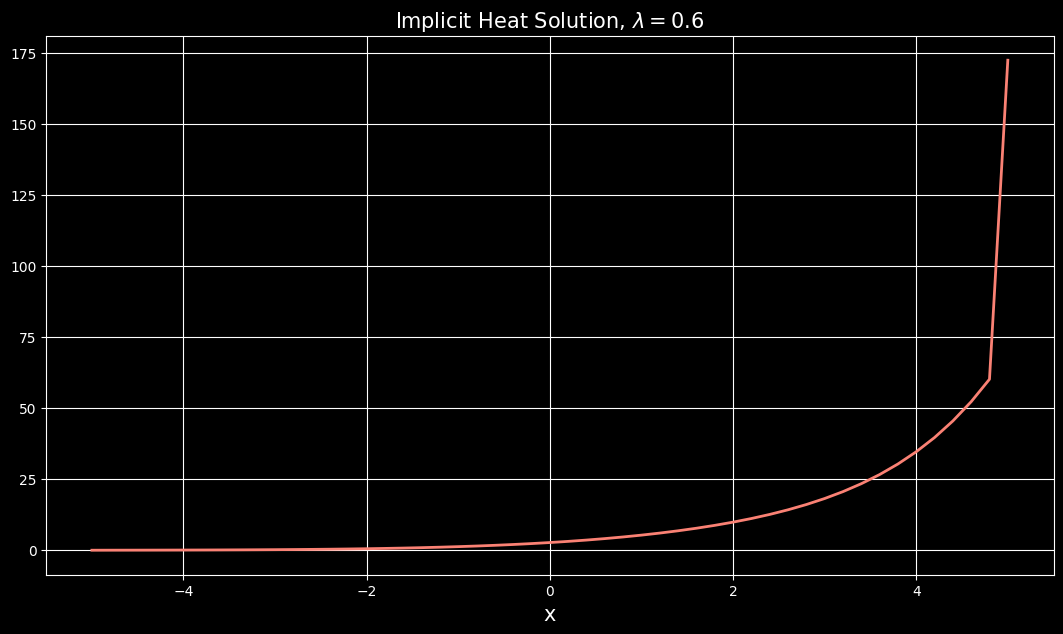

In [29]:
x, w = compute_implicit_call(k, x_min, x_max, delta_x, delta_tau)
plt.figure(figsize=(13, 7))
plt.plot(x, w, 'C3', lw=2)
plt.title('Implicit Heat Solution, $\lambda = 0.6$', fontsize=15)
plt.xlabel('x', color='white', fontsize=15)
plt.grid()
plt.show()

#### 3.2.5 Crank-Nicolson Method
We use the scheme:
\begin{equation}
  w_{i, \nu + 1} - w_{i, \nu} = \frac{\lambda}{2}(w_{i + 1, \nu} - 2w_{i, \nu} + w_{i - 1, \nu} + w_{i + 1, \nu + 1} - 2w_{i, \nu + 1} + w_{i - 1, \nu + 1})
\end{equation}

with the convergence rate $O(\Delta \tau^2, \Delta x^2)$ and unconditional stability.

This can be rewritten as $A w^{(\nu + 1)} = B w^{(\nu)} $ where:
\begin{equation}
   A = \left(
    \begin{array}{ccccc}
      1 + \lambda & -\lambda/2 & 0 & \ldots & 0 \\
      -\lambda/2 & 1 + \lambda & \ddots & \ddots & \vdots \\
      0 & \ddots & \ddots & \ddots & 0 \\
      \vdots & \ddots & \ddots & \ddots & -\lambda/2 \\
      0 & \ldots & 0 & -\lambda/2 & 1 + \lambda
    \end{array}
  \right),
  B = \left(
    \begin{array}{ccccc}
      1 - \lambda & \lambda/2 & 0 & \ldots & 0 \\
      \lambda/2 & 1 - \lambda & \ddots & \ddots & \vdots \\
      0 & \ddots & \ddots & \ddots & 0 \\
      \vdots & \ddots & \ddots & \ddots & \lambda/2 \\
      0 & \ldots & 0 & \lambda/2 & 1 - \lambda
    \end{array}
  \right)
\end{equation}

Accordingly, we choose boundary conditions:
\begin{equation}
\begin{aligned}
  &w_{0, \nu} = r_1(\tau, x) \\
  &w_{m, \nu} = r_2(\tau, x)
\end{aligned}
\end{equation}
where $y(\tau, x) \rightarrow r_1(\tau, x)$ for $x \rightarrow -\infty$ and $y(\tau, x) \rightarrow r_2(\tau, x)$ for $x \rightarrow +\infty$.

With those boundary conditions, we have to solve at each step:
$$
A w^{(\nu + 1)} = B w^{(\nu)} + d^{(\nu)}
$$ 

where

\begin{equation}
  d^{(\nu)} = \frac{\lambda}{2} \left(
    \begin{array}{c}
      w_{0, \nu} + w_{0, \nu + 1} \\
      0\\
      \vdots \\
      0 \\
      w_{m, \nu} + w_{m, \nu + 1}
    \end{array}
  \right)
\end{equation}

In [30]:
@nb.njit()
def get_crank_A_matrix(m, lambda_):
    A = np.zeros((m + 1, m + 1))
    for i in range(m):
        A[i][i] = 1 + lambda_
        A[i][i + 1] = -lambda_ / 2
        A[i + 1][i] = -lambda_ / 2
    A[m][m] = 1 + lambda_
    return A

@nb.njit()
def get_crank_B_matrix(m, lambda_):
    B = np.zeros((m + 1, m + 1))
    for i in range(m):
        B[i][i] = 1 - lambda_
        B[i][i + 1] = lambda_ / 2
        B[i + 1][i] = lambda_ / 2
    B[m][m] = 1 - lambda_
    return B

@nb.njit()
def crank_call(w, A, B, k, w_m, w_0, nu, lambda_):
    d = np.zeros(len(w))
    d[0] = lambda_ / 2 * (w_0[nu] + w_0[nu + 1])
    d[-1] = lambda_ / 2 * (w_m[nu] + w_m[nu + 1])
    return np.linalg.inv(A).dot(B.dot(w) + d)

In [31]:
@nb.njit()
def price_european_call(K, T, r, sigma, x_min, x_max, delta_x, delta_tau):
    k = 2 * r / sigma ** 2
    tau_max = T * (sigma ** 2) / 2
    x = np.arange(x_min, x_max + delta_x, delta_x)
    m = int((x_max - x_min) / delta_x)
    lambda_ = delta_tau / (delta_x ** 2)
    tau_array = np.arange(0, tau_max + delta_tau, delta_tau)

    A = get_crank_A_matrix(m, lambda_)
    B = get_crank_B_matrix(m, lambda_)
    w = get_call_maturity_condition(x_min, x_max, delta_x, k)
    w_m = np.exp((k + 1) * x_max / 2 + ((k + 1) ** 2) * tau_array / 4)
    w_0 = np.zeros(len(w_m))
    for nu in range((len(w_m)) - 1):
        w = crank_call(w, A, B, k, w_m, w_0, nu, lambda_)

    alpha = (1 - k) / 2
    beta = - (k + 1) ** 2 / 4
    V = K * np.exp(alpha * x + beta * tau_max) * w
    S = K * np.exp(x)
    return S, V

In [32]:
r = 0.01
sigma = 0.3
K = 100
T = 1
x_min = -5
x_max = 5
delta_x = 0.01
delta_tau = 0.002
S, V = price_european_call(K, T, r, sigma, x_min, x_max, delta_x, delta_tau)

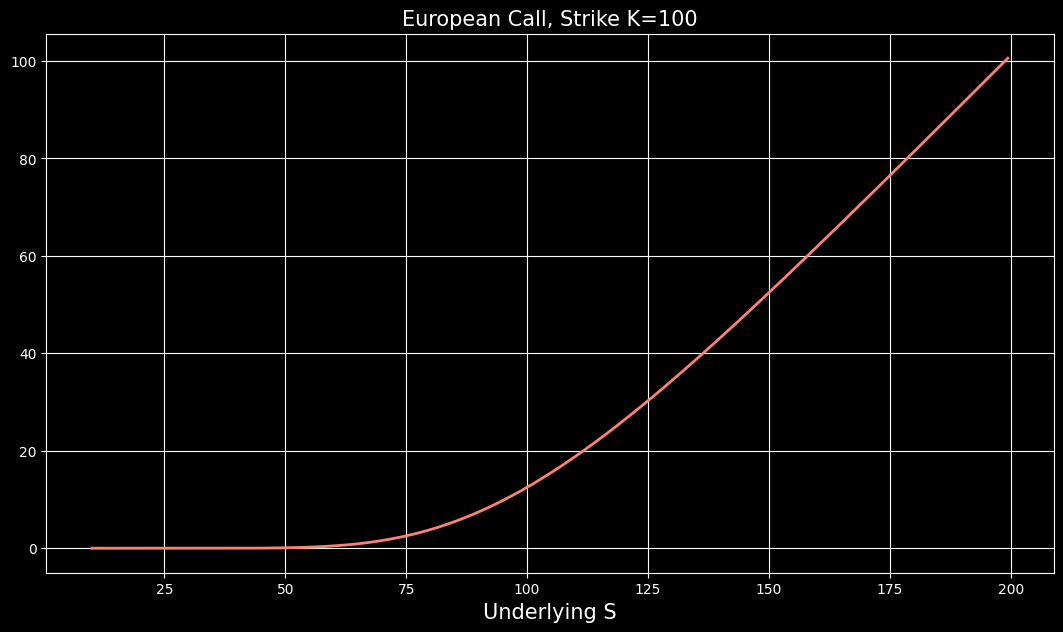

In [33]:
plt.figure(figsize=(13, 7))
plt.plot(S[(S < 200) & (S > 10)], V[(S < 200) & (S > 10)], 'C3', lw=2)
plt.title('European Call, Strike K=100', fontsize=15)
plt.xlabel('Underlying S', color='white', fontsize=15)
plt.grid()
plt.show()

#### 3.2.6 Exercise: Convergence
Check experimentally that the convergence rates stated above hold for all three different methods.

#### 3.2.7 American Put Option 
Finite differences approach (Crank-Nicolson) can be used for valuation of American options.
However, it is more difficult because option can be exercised at any time.

In this situation, dynamic programming leads to a system of inequalities instead of one equation:
$$
\left.\begin{array}{r}
\left(\frac{\partial y}{\partial \tau}-\frac{\partial^2 y}{\partial x^2}\right)(y-g)=0 \\
\frac{\partial y}{\partial \tau}-\frac{\partial^2 y}{\partial x^2} \geq 0 \\
y-g \geq 0
\end{array}\right\}
$$

where $g$ corresponds to the put's payoff (in the transformed Black-Scholes equation):
$$
g(\tau, x) = \exp \left(\frac{1}{4}(k+1)^{2}\tau\right) \left(e^{(k-1)x/2} - e^{(k+1)x/2} \right)^{+}
$$

For this type of problem we should use Brennan-Schwartz algorithm to make implicit steps in Crank-Nicolson method.

#### 3.2.8 Implementing Brennan-Schwartz algorithm

The algorithm is based on a Gaussian elimination where the early
exercise constraint is handled in a simple manner.
At each time step $\nu$, the problem needs to be solved:
$$
\left\{\begin{array}{c}
Aw^{(\nu+1)} \geq b^{(\nu)} \\
w^{(\nu+1)} \geq g \\
\left(Aw^{(\nu+1)}-b^{(\nu)}\right)^T\left(w^{(\nu+1)}-g\right)=0
\end{array}\right.
$$

The algorithm is the following: The Gaussian elimination transforms rows of the system of linear equations $Aw=b$ to the form:
$$
p_i w_i+s_i w_{i+1}=k_i, \ \ \ (*)
$$
for $i=1, \ldots, m$, where the coefficients can be chosen to be
$$
\begin{gathered}
p_1=a_{11}, \quad s_1=a_{12}, \quad k_1=b_1 \\
p_i=a_{i i}-\frac{a_{i i-1}}{p_{i-1}} a_{i-1 i}, \quad s_i=a_{i i+1}, \quad k_i=b_i-\frac{a_{i i-1}}{p_{i-1}} k_{i-1} \\
p_m=a_{m m}-\frac{a_{m m-1}}{p_{m-1}} a_{m-1 m} \quad \text { and } \quad k_m=b_m-\frac{p_{m-1}}{a_{m m-1}} k_{m-1}
\end{gathered}
$$

The solution $y$ for the system of inequalities above is obtained by using the equation (*) and the payoff function of the put option.
We start with solving from $i = m$, if $w_m$ is less than the payoff value then set $w_m = g_m$. Then solve $w_{m−1}$ and so on...

Original algorithm can be found in the article [BrennanSchwartz1977].

C++ implementation with LibTorch can be found in `src/noa/quant/bsm.hh`.

In [34]:
%pycat pyquant/bsm.py

import math
import numpy as np
import numba as nb
from typing import Tuple, List


@nb.njit()
def _brennan_schwartz(alpha: np.array, beta: np.array, gamma: np.array, b, g):
    """Computes solution to Ax - b >= 0 ; x >= g and (Ax-b)'(x-g)=0.
    A is a tridiagonal matrix with alpha, beta, gamma coefficients.

    Args:
        alpha: Main diagonal of A.  Shape: (npoints_S,).
        beta:  Upper diagonal of A. Shape: (npoints_S - 1,).
        gamma: Lower diagonal of A. Shape: (npoints_S - 1,).
        b, g
    """
    n = len(alpha)
    alpha_hat = np.zeros(n, dtype=np.float64)
    b_hat = np.zeros(n, dtype=np.float64)
    alpha_hat[-1] = alpha[-1]
    b_hat[-1] = b[-1]

    for i in range(n - 2, -1, -1):
        alpha_hat[i] = alpha[i] - beta[i] * gamma[i] / alpha_hat[i + 1]
        b_hat[i] = b[i] - beta[i] * b_hat[i + 1] / alpha_hat[i + 1]

    x = np.zeros(n, dtype=np.float64)
    x[0] = np.maximum(b_hat[0] / alpha_hat[0], g[0])
    for i in range(1, n):
        x[i] = np.maximum(

In [35]:
from pyquant.bsm import price_american_put_bs, find_early_exercise

In [37]:
STRIKE = 50
T = 1
RATE = 0.01
SIGMA = 0.3

V, S_array, t_array = price_american_put_bs(
    STRIKE, T, RATE, SIGMA, S_min=20, S_max=100, npoints_S=500, npoints_t=500)

delta_tau / delta_x**2 = 8.668912200803744


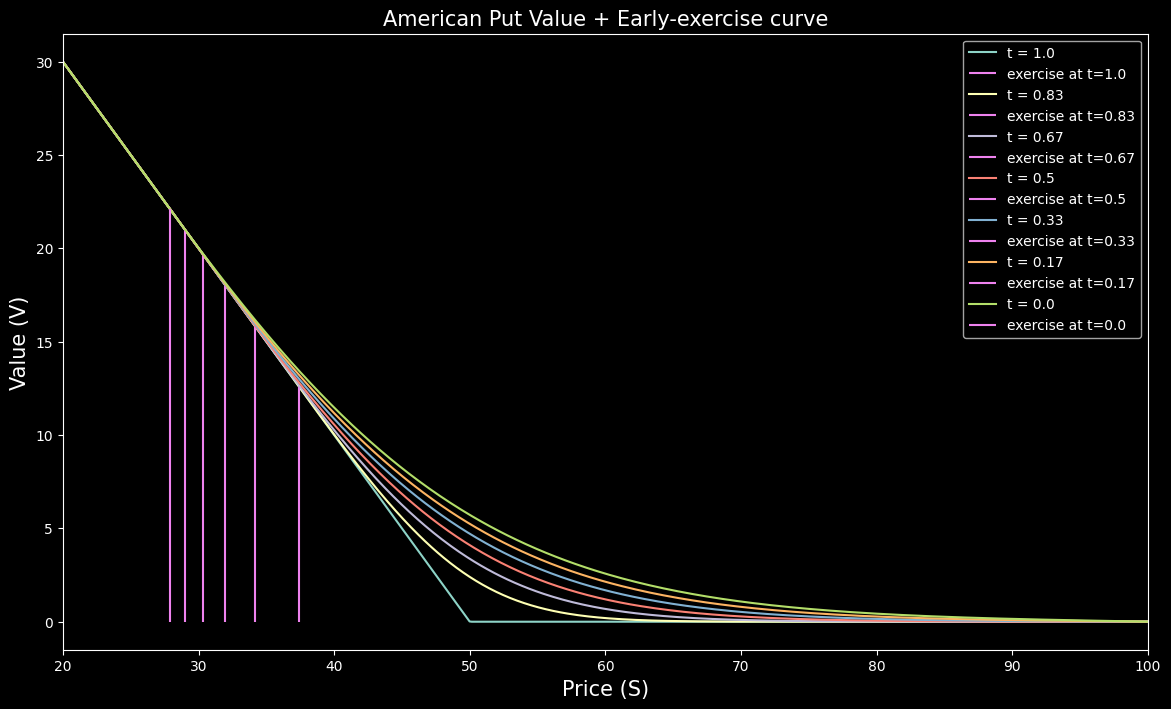

In [38]:
plt.figure(figsize=(14, 8))
indexes = np.linspace(0, len(t_array) - 1, 7).astype(int)
for i in indexes:
    plt.plot(S_array, V[:, i], label=f't = {round(t_array[i], 2)}')
    stop_line = [(s,v) for v,s in zip(V[:, i], S_array) if v <= max(STRIKE-s, 0)]
    plt.vlines(stop_line[-1][0], ymin=0, ymax=stop_line[-1][1], color='violet', label=f'exercise at t={round(t_array[i], 2)}')
plt.legend()
plt.xlim(20, 100)
plt.xlabel('Price (S)', color='white', fontsize=15)
plt.ylabel('Value (V)', color='white', fontsize=15)
plt.title('American Put Value + Early-exercise curve', fontsize=15)
plt.show()

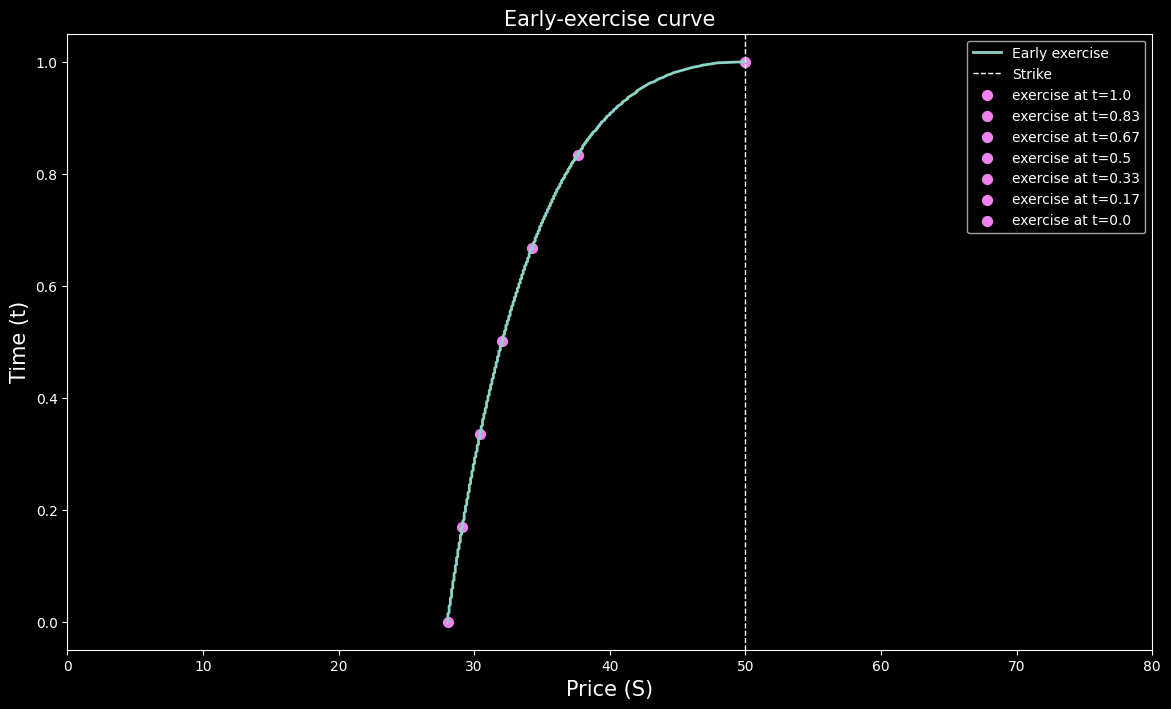

In [39]:
stop_line_V, stop_line_S = find_early_exercise(V, S_array, t_array, STRIKE)

plt.figure(figsize=(14, 8))
plt.plot(stop_line_S, t_array, label='Early exercise', lw=2)
plt.axvline(STRIKE, ls='--', label='Strike', lw=1)
for i in indexes:
    plt.scatter(stop_line_S[i], t_array[i], color='violet', s=50,
                label=f'exercise at t={round(t_array[i], 2)}')
plt.ylabel('Time (t)', color='white', fontsize=15)
plt.xlabel('Price (S)', color='white', fontsize=15)
plt.title('Early-exercise curve', fontsize=15)
plt.xlim(0, 80)
plt.legend()
plt.show()

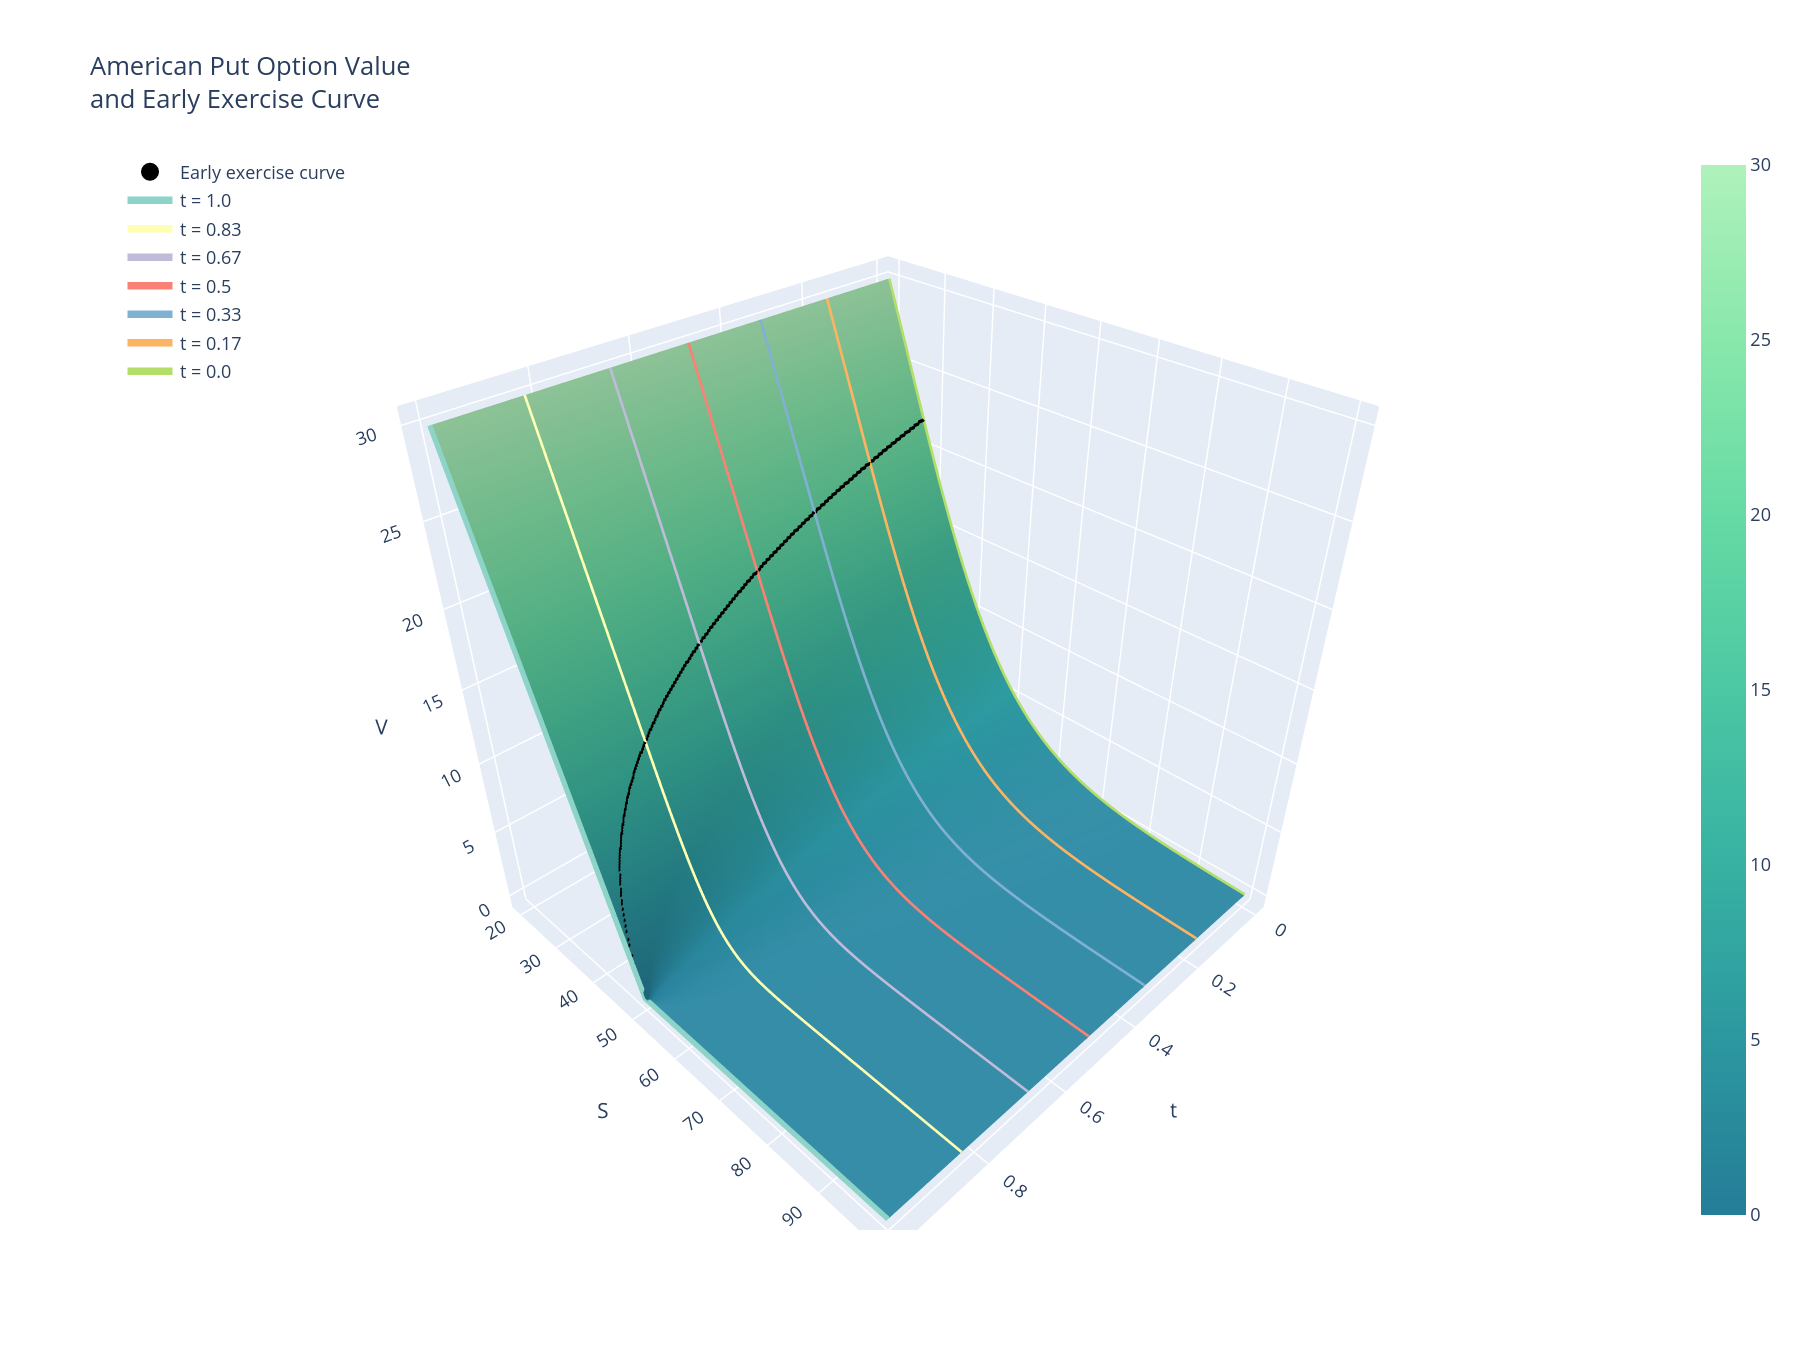

In [40]:
surface = go.Surface(z=V, x=t_array, y=S_array, colorscale='Tealgrn_r')
early_curve = go.Scatter3d(z=stop_line_V, x=t_array, y=stop_line_S, mode='markers',
                           marker=dict(size=1.5, color='black'), name='Early exercise curve')
mpl_colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
slices = [
    go.Scatter3d(
        z=V[:, i],
        x=np.full_like(t_array, t_array[i]),
        y=S_array,
        mode='lines',
        line=dict(width=7, color=next(mpl_colors)),
        name=f't = {round(t_array[i], 2)}'
    ) for i in indexes
]
figA = go.Figure([surface, early_curve] + slices)
figA.update_layout(title='American Put Option Value<br>and Early Exercise Curve',
                   legend=dict(x=0, itemsizing='constant'))
figA.update_scenes(xaxis_title_text='t', yaxis_title_text='S', zaxis_title_text='V')
figA.show(renderer='png', width=1200, height=900, scale=1.5)

See on interactive plot:

In [ ]:
figA.show()

## References

* [Seydel2017] Seydel, R.U. Tools for Computational Finance, 6th edition, Springer V., London (2017).
* [Shreve2004] Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* [BrennanSchwartz1977] Brennan, M. J., Schwartz, E. S. (1977). The valuation of American put options. The Journal of Finance, 32(2), 449-462.
